In [1]:
# 导入必要的Python库
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [2]:
# 读取交通事故数据集
df = pd.read_csv('dft-road-casualty-statistics-collision-2023.csv', low_memory=False)

# 查看数据基本信息
print("数据集基本信息：")
print(df.info())
df.head()

数据集基本信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104258 entries, 0 to 104257
Data columns (total 37 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   accident_index                               104258 non-null  object 
 1   accident_year                                104258 non-null  int64  
 2   accident_reference                           104258 non-null  object 
 3   location_easting_osgr                        104246 non-null  float64
 4   location_northing_osgr                       104246 non-null  float64
 5   longitude                                    104246 non-null  float64
 6   latitude                                     104246 non-null  float64
 7   police_force                                 104258 non-null  int64  
 8   accident_severity                            104258 non-null  int64  
 9   number_of_vehicles                           10425

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location,enhanced_severity_collision
0,2023010419171,2023,010419171,525060.0,170416.0,-0.202878,51.418974,1,3,1,...,4,8,2,0,0,1,1,2,E01003383,-1
1,2023010419183,2023,010419183,535463.0,198745.0,-0.042464,51.671155,1,3,3,...,4,1,1,0,0,1,1,2,E01001547,-1
2,2023010419189,2023,010419189,508702.0,177696.0,-0.435789,51.487777,1,3,2,...,4,1,1,0,0,1,1,2,E01002448,-1
3,2023010419191,2023,010419191,520341.0,190175.0,-0.263972,51.597575,1,3,2,...,4,9,1,0,0,1,1,2,E01000129,-1
4,2023010419192,2023,010419192,527255.0,176963.0,-0.168976,51.477324,1,3,2,...,4,1,1,0,0,1,1,2,E01004583,-1


In [3]:
# 选取与预测相关的重要字段
selected_cols = [
    'accident_severity', 'number_of_vehicles', 'number_of_casualties',
    'date', 'time', 'day_of_week', 'road_type', 'speed_limit',
    'light_conditions', 'weather_conditions', 'road_surface_conditions',
    'urban_or_rural_area'
]

df_selected = df[selected_cols].copy()

print("选取后的字段：")
print(df_selected.head())


选取后的字段：
   accident_severity  number_of_vehicles  number_of_casualties        date  \
0                  3                   1                     1  01/01/2023   
1                  3                   3                     2  01/01/2023   
2                  3                   2                     1  01/01/2023   
3                  3                   2                     1  01/01/2023   
4                  3                   2                     1  01/01/2023   

    time  day_of_week  road_type  speed_limit  light_conditions  \
0  01:24            1          2           20                 4   
1  02:25            1          6           30                 4   
2  03:50            1          1           30                 4   
3  02:13            1          6           30                 4   
4  01:42            1          6           30                 4   

   weather_conditions  road_surface_conditions  urban_or_rural_area  
0                   8                        2    

In [4]:
# 针对每一列进行缺失值处理
# 数值型字段用中位数填充，类别型字段用众数填充
for col in df_selected.columns:
    if df_selected[col].isnull().sum() > 0:
        if df_selected[col].dtype in ['float64', 'int64']:
            df_selected[col].fillna(df_selected[col].median(), inplace=True)
        else:
            df_selected[col].fillna(df_selected[col].mode()[0], inplace=True)

print("缺失值处理完成。")


缺失值处理完成。


In [5]:
# 处理 date 列，提取 month
df_selected['date'] = pd.to_datetime(df_selected['date'], format='%d/%m/%Y', errors='coerce')
df_selected['month'] = df_selected['date'].dt.month

# 处理 time 列，提取 hour
df_selected['hour'] = pd.to_datetime(df_selected['time'], format='%H:%M', errors='coerce').dt.hour

# 删除原来的 date 和 time 列
df_selected.drop(['date', 'time'], axis=1, inplace=True)

print("时间特征提取完成！")


时间特征提取完成！


In [6]:
from sklearn.preprocessing import LabelEncoder

categorical_features = ['road_type', 'light_conditions', 'weather_conditions', 'road_surface_conditions', 'urban_or_rural_area']
encoder = LabelEncoder()
for col in categorical_features:
    df_selected[col] = encoder.fit_transform(df_selected[col])

print("类别特征编码完成！")


类别特征编码完成！


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
# 特征和目标分开
X = df_selected.drop('accident_severity', axis=1)  # 输入特征
y = df_selected['accident_severity']               # 目标变量


In [9]:
# 切分数据集（70%训练，30%测试）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("训练集大小：", X_train.shape)
print("测试集大小：", X_test.shape)


训练集大小： (72980, 11)
测试集大小： (31278, 11)


In [10]:
# 初始化并训练决策树
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

print("决策树模型训练完成！")


决策树模型训练完成！


In [11]:
# 在测试集上进行预测
y_pred = model.predict(X_test)

# 评估指标输出
print("模型准确率 (Accuracy):", accuracy_score(y_test, y_pred))
print("\n分类详细报告 (Classification Report):\n", classification_report(y_test, y_pred))


模型准确率 (Accuracy): 0.6409297269646397

分类详细报告 (Classification Report):
               precision    recall  f1-score   support

           1       0.04      0.05      0.04       454
           2       0.27      0.28      0.27      7198
           3       0.77      0.76      0.77     23626

    accuracy                           0.64     31278
   macro avg       0.36      0.36      0.36     31278
weighted avg       0.65      0.64      0.64     31278



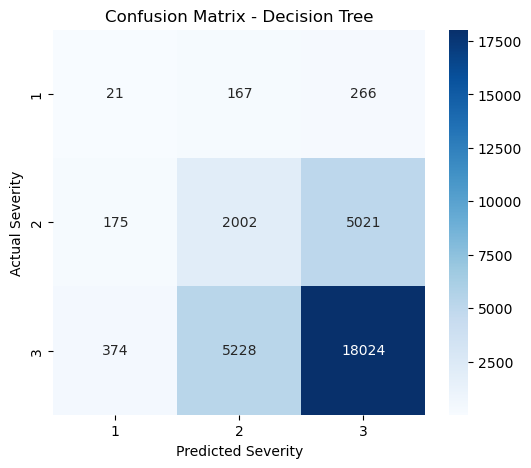

In [12]:
# 绘制混淆矩阵
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1,2,3], yticklabels=[1,2,3])
plt.xlabel('Predicted Severity')
plt.ylabel('Actual Severity')
plt.title('Confusion Matrix - Decision Tree')
plt.show()


In [13]:
from sklearn.ensemble import RandomForestClassifier


In [14]:
# 初始化Random Forest（可以先用默认参数）
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

print("Random Forest模型训练完成！")


Random Forest模型训练完成！


In [15]:
# 预测
y_pred_rf = rf_model.predict(X_test)

# 评估
print("Random Forest模型准确率 (Accuracy):", accuracy_score(y_test, y_pred_rf))
print("\nRandom Forest分类详细报告 (Classification Report):\n", classification_report(y_test, y_pred_rf))


Random Forest模型准确率 (Accuracy): 0.7155508664236844

Random Forest分类详细报告 (Classification Report):
               precision    recall  f1-score   support

           1       0.06      0.01      0.02       454
           2       0.31      0.14      0.19      7198
           3       0.77      0.90      0.83     23626

    accuracy                           0.72     31278
   macro avg       0.38      0.35      0.35     31278
weighted avg       0.65      0.72      0.67     31278



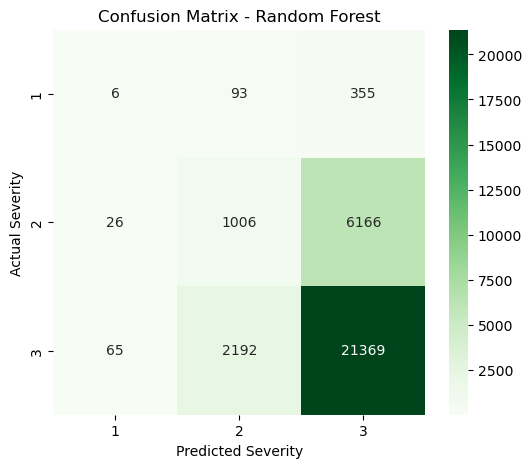

In [16]:
# 混淆矩阵
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6,5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', xticklabels=[1,2,3], yticklabels=[1,2,3])
plt.xlabel('Predicted Severity')
plt.ylabel('Actual Severity')
plt.title('Confusion Matrix - Random Forest')
plt.show()
